MNE Version : 1.10.1
Using device: cuda
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 249)

Star

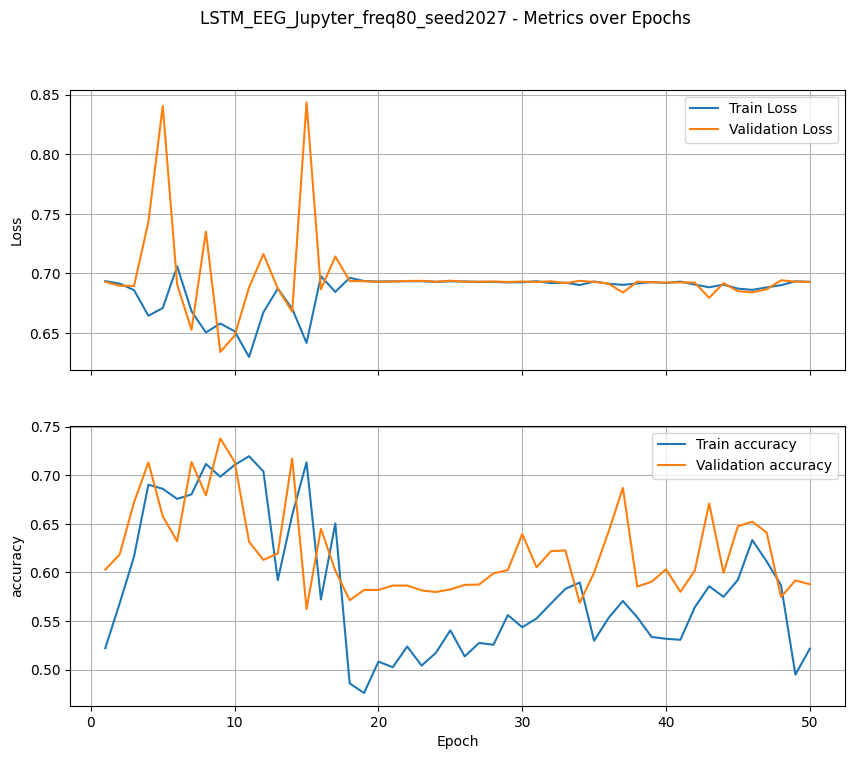

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
from sklearn.metrics import roc_auc_score

# Make sure Load_PhysioNet_EEG.py is in the same directory or aucessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration
# ===================================================================
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=50,  # Number of subjects
    seed=2027     # Random seed
)

# --- Hyperparameters ---
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
HIDDEN_SIZE = 64
NUM_LAYERS = 2
exp_name = f"LSTM_EEG_Jupyter_freq{args.freq}_seed{args.seed}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def calculate_auc(y_pred_logit, y_true):
    # Get probabilities from logits
    y_pred_prob = torch.sigmoid(y_pred_logit)
    
    # Detach tensors from the computation graph and move to CPU/NumPy for sklearn
    y_pred_prob_numpy = y_pred_prob.cpu().detach().numpy()
    y_true_numpy = y_true.cpu().detach().numpy()
    
    # Calculate and return the AUC score
    return roc_auc_score(y_true_numpy, y_pred_prob_numpy)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_auc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, Y_batch)
        auc = calculate_auc(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_auc += auc
    return total_loss / len(loader), total_auc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_auc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = loss_fn(output, Y_batch)
            auc = calculate_auc(output, Y_batch)
            total_loss += loss.item()
            total_auc += auc
    return total_loss / len(loader), total_auc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_auc'], label='Train accuracy')
    ax2.plot(df_metrics['epoch'], df_metrics['val_auc'], label='Validation accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- Setup ---
torch.manual_seed(args.seed)
np.random.seed(args.seed)
print(f"Using device: {device}")

# --- Data Loading ---
train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
    seed=args.seed, device=device, batch_size=BATCH_SIZE, 
    sampling_freq=args.freq, sample_size=args.n_sample
)

# --- Model Initialization ---
model = LSTMModel(input_size=input_dim[1], hidden_size=HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
metrics = {'epoch': [], 'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': [], 'test_loss': [], 'test_auc': []}
print("\nStarting training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_auc = train_epoch(model, optimizer, train_loader, loss_fn, device)
    val_loss, val_auc = test_epoch(model, val_loader, loss_fn, device)
    test_loss, test_auc = (test_epoch(model, test_loader, loss_fn, device) if epoch == EPOCHS - 1 else (np.nan, np.nan))
    
    metrics['epoch'].append(epoch + 1)
    metrics['train_loss'].append(train_loss); metrics['train_auc'].append(train_auc)
    metrics['val_loss'].append(val_loss); metrics['val_auc'].append(val_auc)
    metrics['test_loss'].append(test_loss); metrics['test_auc'].append(test_auc)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_time:.2f}s] - Train Loss: {train_loss:.4f}, auc: {train_auc:.4f} | Val Loss: {val_loss:.4f}, auc: {val_auc:.4f}")

print("\n--- Training Complete ---")
print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test auc: {metrics['test_auc'][-1]:.4f}")

save_and_plot_metrics(exp_name, metrics)

### Hyperparameter tuning

STAGE 1: Starting Grid Search using Seed: 2025
Using device: cuda
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set s

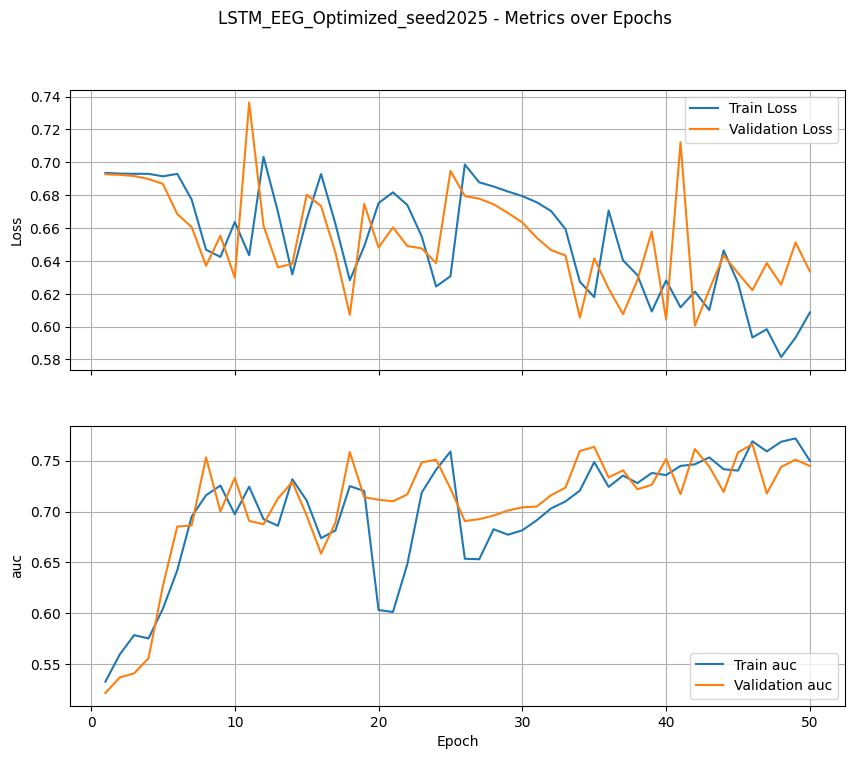


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
77 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
21 bad epochs dropped

Training set shape: (1498, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (339, 64, 2

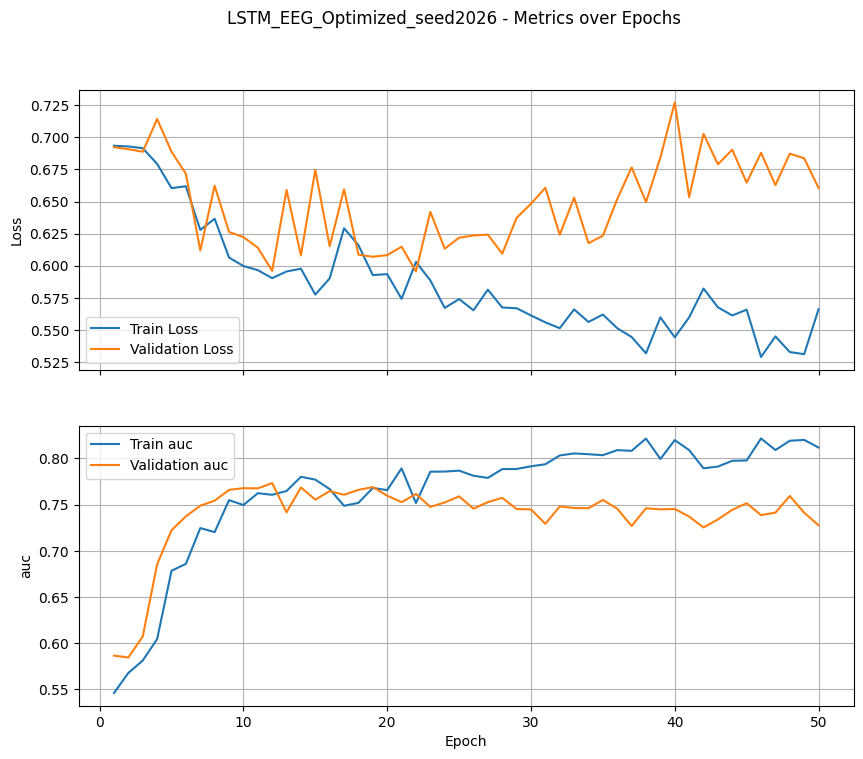


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 2

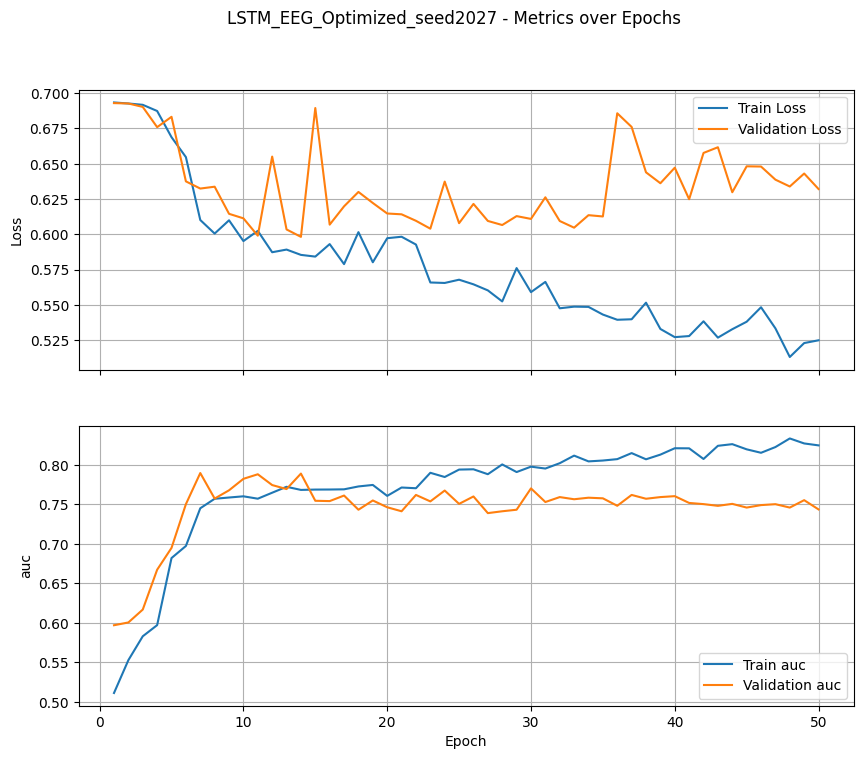


Grid search results saved to LSTM_EEG_Optimized_seed2025/grid_search_results.csv


In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
from sklearn.metrics import roc_auc_score

# Make sure Load_PhysioNet_EEG.py is in the same directory or aucessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=50   # Number of subjects
)

# --- Seed Configuration ---
TUNING_SEED = 2025
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
GRID_SEARCH_EPOCHS = 50
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Grid Search Hyperparameters ---
param_grid = {
    'hidden_size': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005],
    'dropout': [0.2, 0.3]
}

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_auc(y_pred_logit, y_true):
    # Get probabilities from logits
    y_pred_prob = torch.sigmoid(y_pred_logit)
    
    # Detach tensors from the computation graph and move to CPU/NumPy for sklearn
    y_pred_prob_numpy = y_pred_prob.cpu().detach().numpy()
    y_true_numpy = y_true.cpu().detach().numpy()
    
    # Calculate and return the AUC score
    return roc_auc_score(y_true_numpy, y_pred_prob_numpy)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_auc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, Y_batch)
        auc = calculate_auc(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_auc += auc
    return total_loss / len(loader), total_auc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_auc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = loss_fn(output, Y_batch)
            auc = calculate_auc(output, Y_batch)
            total_loss += loss.item()
            total_auc += auc
    return total_loss / len(loader), total_auc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_auc'], label='Train auc')
    ax2.plot(df_metrics['epoch'], df_metrics['val_auc'], label='Validation auc')
    ax2.set_ylabel('auc')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- STAGE 1: HYPERPARAMETER TUNING ON A SINGLE SEED ---
print("="*50)
print(f"STAGE 1: Starting Grid Search using Seed: {TUNING_SEED}")
print("="*50)

# --- Setup and Data Loading for Tuning ---
torch.manual_seed(TUNING_SEED)
np.random.seed(TUNING_SEED)
print(f"Using device: {device}")
train_loader, val_loader, _, input_dim = load_eeg_ts_revised(
    seed=TUNING_SEED, device=device, batch_size=BATCH_SIZE, 
    sampling_freq=args.freq, sample_size=args.n_sample
)

# --- Grid Search ---
best_val_auc = 0.0
best_params = {}
grid_search_results = []

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for i, params in enumerate(param_combinations):
    print(f"\n[{i+1}/{len(param_combinations)}] Testing params: {params}")
    
    model = LSTMModel(
        input_size=input_dim[1], hidden_size=params['hidden_size'], 
        output_size=1, num_layers=params['num_layers'], dropout=params['dropout']
    ).to(device)
    
    print(f"Number of trainable parameters: {count_parameters(model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    for epoch in range(GRID_SEARCH_EPOCHS):
        train_loss, train_auc = train_epoch(model, optimizer, train_loader, loss_fn, device)
    
    val_loss, val_auc = test_epoch(model, val_loader, loss_fn, device)
    print(f"Validation auc for params {params}: {val_auc:.4f}")
    grid_search_results.append({'params': str(params), 'val_auc': val_auc})

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_params = params

print(f"\n--- Grid Search Complete ---")
print(f"Best Validation auc: {best_val_auc:.4f}")
print(f"Best Hyperparameters Found: {best_params}")

# --- STAGE 2: FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_EEG_Optimized_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = LSTMModel(
        input_size=input_dim[1], hidden_size=best_params['hidden_size'], 
        output_size=1, num_layers=best_params['num_layers'], dropout=best_params['dropout']
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

    metrics = {'epoch': [], 'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': [], 'test_loss': [], 'test_auc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_auc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_auc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_auc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_auc'].append(train_auc)
        metrics['val_loss'].append(val_loss); metrics['val_auc'].append(val_auc)
        metrics['test_loss'].append(test_loss); metrics['test_auc'].append(test_auc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train auc: {train_auc:.4f}, Val auc: {val_auc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test auc: {metrics['test_auc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"LSTM_EEG_Optimized_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")


### Parameter-constrained setting


STAGE 2: Starting Final Evaluation for Seeds: [2025, 2026, 2027]

--- Running Final Experiment for Seed: 2025 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249

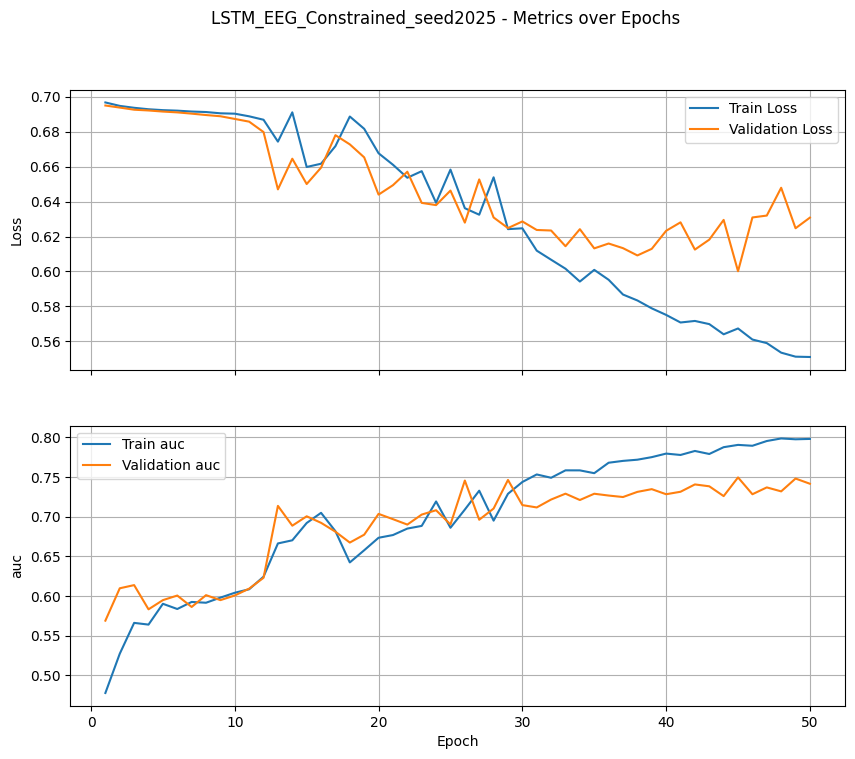


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
77 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
21 bad epochs dropped

Training set shape: (1498, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (339, 64, 2

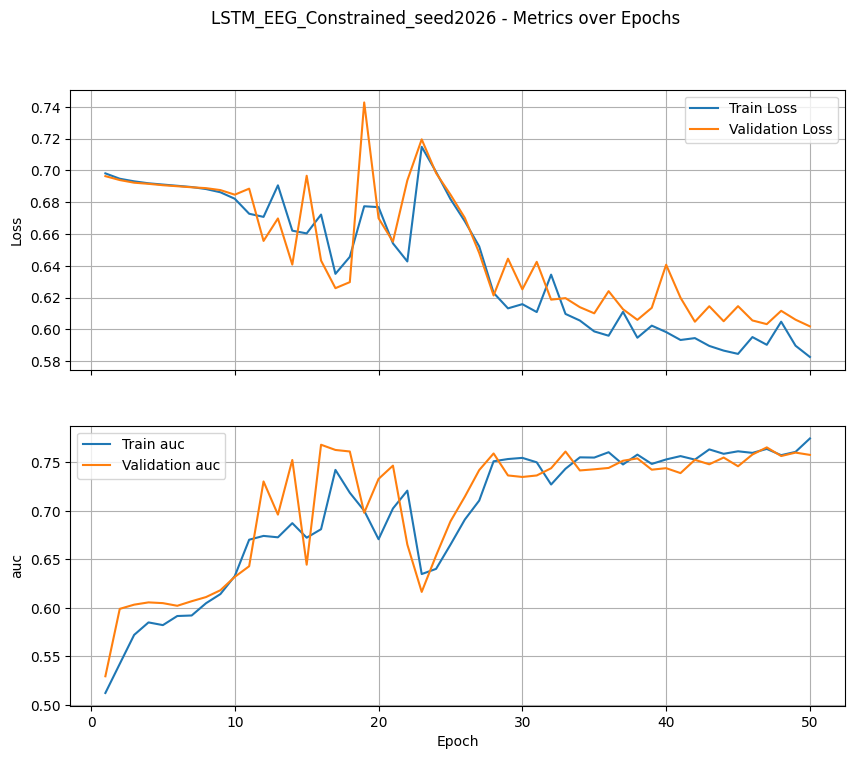


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 2

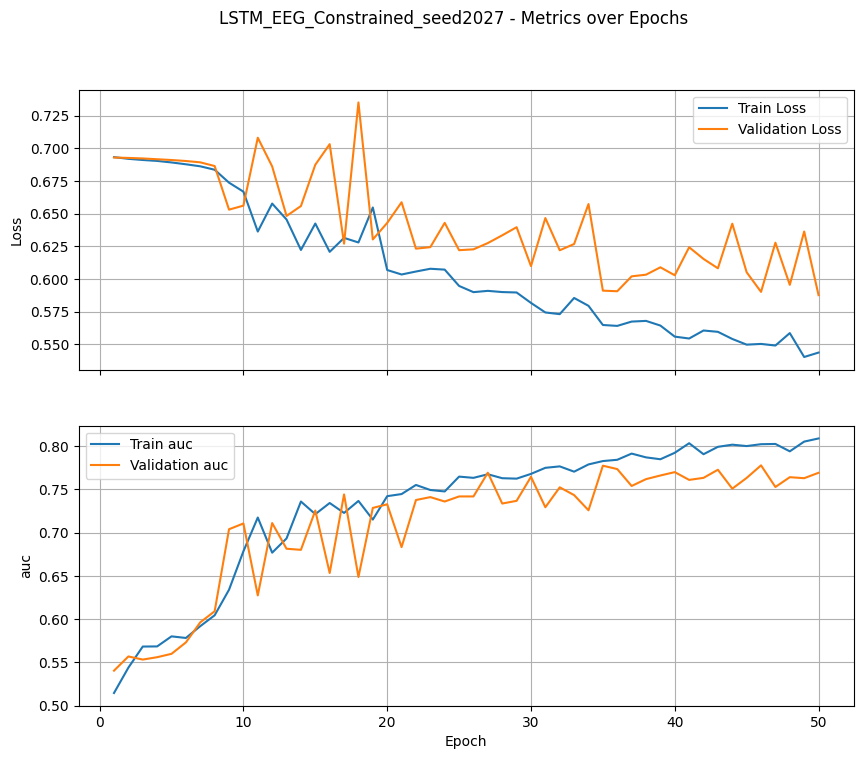


Grid search results saved to LSTM_EEG_Constrained_seed2025/grid_search_results.csv


In [3]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
from sklearn.metrics import roc_auc_score

# Make sure Load_PhysioNet_EEG.py is in the same directory or aucessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=50   # Number of subjects
)

# --- Seed Configuration ---
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---q
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_auc(y_pred_logit, y_true):
    # Get probabilities from logits
    y_pred_prob = torch.sigmoid(y_pred_logit)
    
    # Detach tensors from the computation graph and move to CPU/NumPy for sklearn
    y_pred_prob_numpy = y_pred_prob.cpu().detach().numpy()
    y_true_numpy = y_true.cpu().detach().numpy()
    
    # Calculate and return the AUC score
    return roc_auc_score(y_true_numpy, y_pred_prob_numpy)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_auc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, Y_batch)
        auc = calculate_auc(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_auc += auc
    return total_loss / len(loader), total_auc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_auc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = loss_fn(output, Y_batch)
            auc = calculate_auc(output, Y_batch)
            total_loss += loss.item()
            total_auc += auc
    return total_loss / len(loader), total_auc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_auc'], label='Train auc')
    ax2.plot(df_metrics['epoch'], df_metrics['val_auc'], label='Validation auc')
    ax2.set_ylabel('auc')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_EEG_Constrained_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = LSTMModel(
        input_size=input_dim[1], hidden_size=16, 
        output_size=1, num_layers=1, dropout=0.3
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005)

    metrics = {'epoch': [], 'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': [], 'test_loss': [], 'test_auc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_auc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_auc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_auc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_auc'].append(train_auc)
        metrics['val_loss'].append(val_loss); metrics['val_auc'].append(val_auc)
        metrics['test_loss'].append(test_loss); metrics['test_auc'].append(test_auc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train auc: {train_auc:.4f}, Val auc: {val_auc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test auc: {metrics['test_auc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"LSTM_EEG_Constrained_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")


### Different sample sizes


STAGE 2: Starting Final Evaluation for Seeds: [2025, 2026, 2027]

--- Running Final Experiment for Seed: 2025 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
15 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 249 original time points ...
3 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
90 matching events found
No baseline correction applied
Using data from preloaded Raw for 90 events and 249 original time points ...
3 bad epochs dropped

Training set shape: (300, 64, 249)
Validati

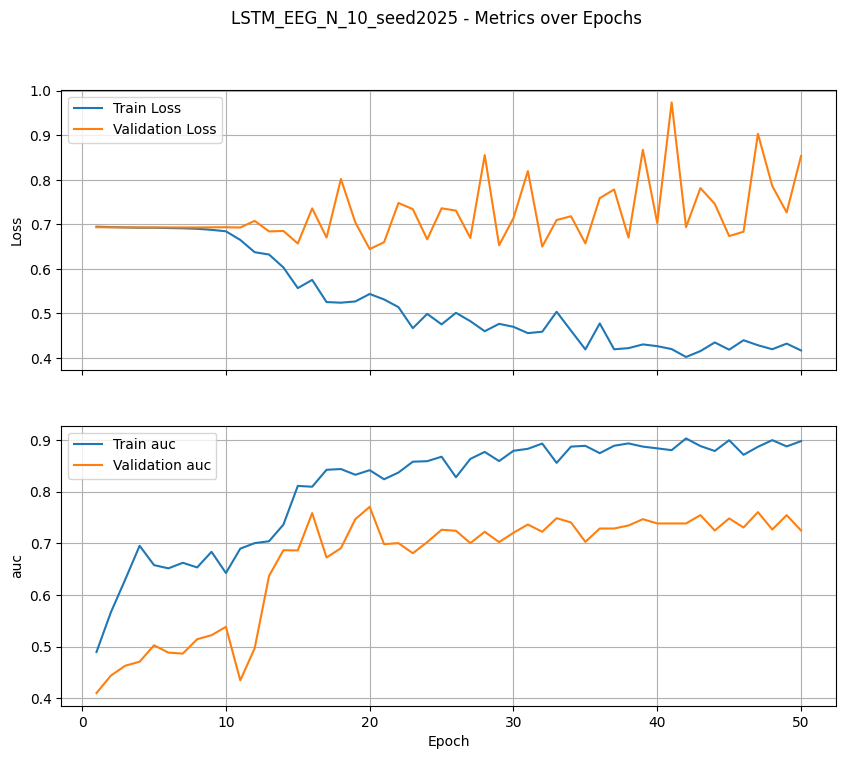


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
12 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 249 original time points ...
3 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
90 matching events found
No baseline correction applied
Using data from preloaded Raw for 90 events and 249 original time points ...
6 bad epochs dropped

Training set shape: (303, 64, 249)
Validation set shape: (42, 64, 249)
Test set shape: (84, 64, 249)
Final mo

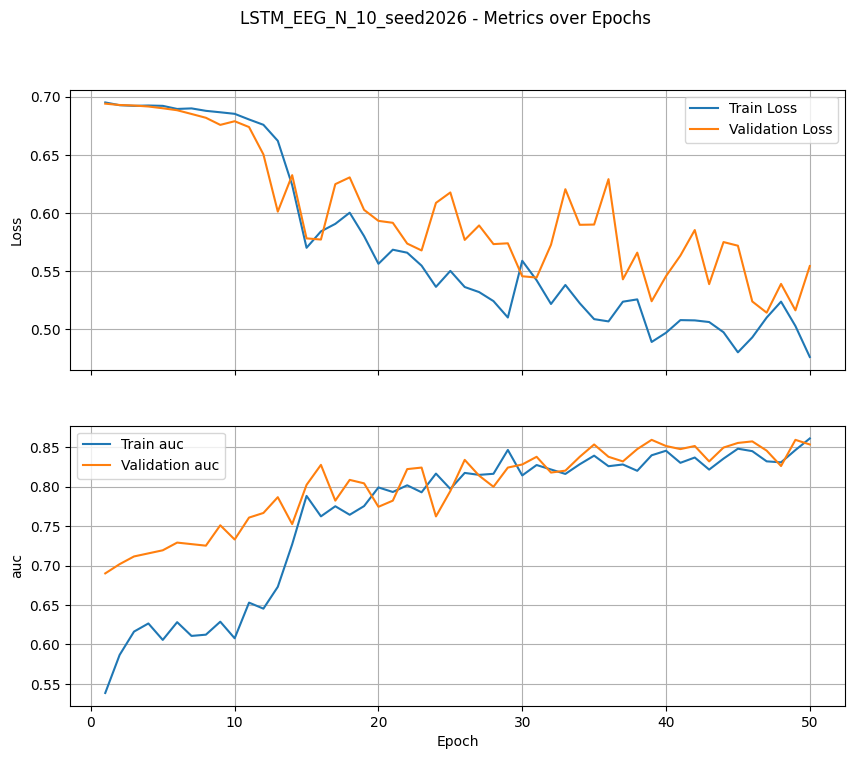


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
15 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 249 original time points ...
0 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
90 matching events found
No baseline correction applied
Using data from preloaded Raw for 90 events and 249 original time points ...
6 bad epochs dropped

Training set shape: (300, 64, 249)
Validation set shape: (45, 64, 249)
Test set shape: (84, 64, 249)
Final mo

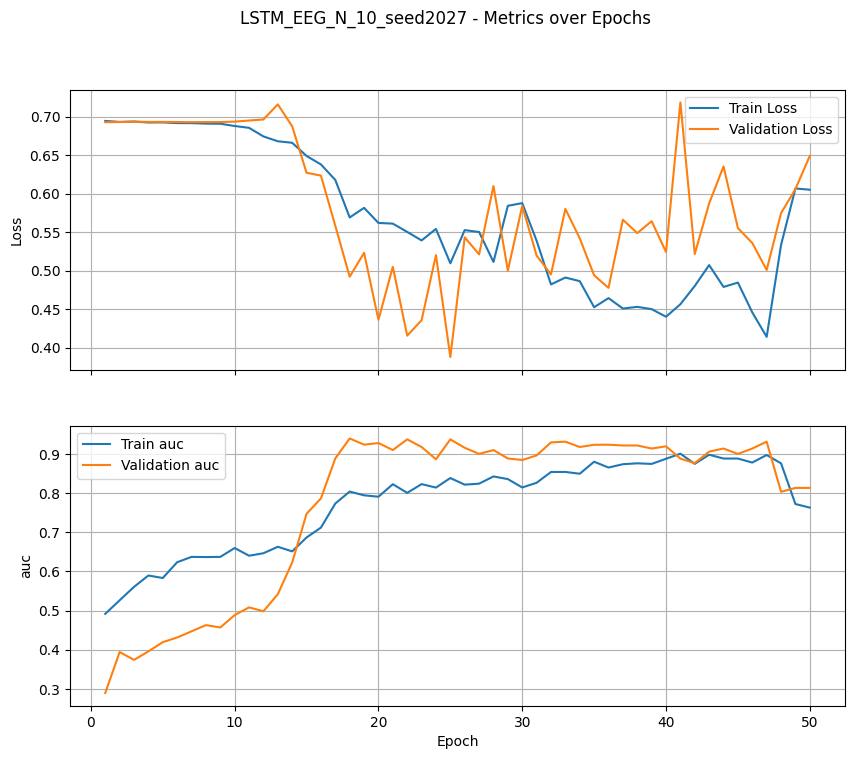


Grid search results saved to LSTM_EEG_N_10_seed2025/grid_search_results.csv


In [11]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
from sklearn.metrics import roc_auc_score

# Make sure Load_PhysioNet_EEG.py is in the same directory or aucessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=10   # Number of subjects
)

# --- Seed Configuration ---
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_auc(y_pred_logit, y_true):
    # Get probabilities from logits
    y_pred_prob = torch.sigmoid(y_pred_logit)

    # Detach tensors for sklearn
    y_pred_prob_numpy = y_pred_prob.cpu().detach().numpy()
    y_true_numpy = y_true.cpu().detach().numpy()

    # Handle the case where a batch contains only one class
    if len(np.unique(y_true_numpy)) == 1:
        # Return a placeholder value (e.g., 0.5 for random guessing, or np.nan to ignore)
        # and let the calling function handle it. Here, we return nan.
        return np.nan
    else:
        return roc_auc_score(y_true_numpy, y_pred_prob_numpy)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss = 0
    auc_scores = []  # <-- 1. Collect scores in a list
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze(-1)
        loss = loss_fn(output, Y_batch)
        
        # Calculate AUC for the batch
        auc = calculate_auc(output, Y_batch)
        auc_scores.append(auc) # <-- 2. Append the score (even if it's nan)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 3. Calculate the mean of the valid AUC scores
    mean_auc = np.nanmean(auc_scores) 
    return total_loss / len(loader), mean_auc

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    auc_scores = [] # <-- 1. Collect scores in a list
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze(-1)
            loss = loss_fn(output, Y_batch)

            # Calculate AUC for the batch
            auc = calculate_auc(output, Y_batch)
            auc_scores.append(auc) # <-- 2. Append the score (even if it's nan)
            
            total_loss += loss.item()

    # 3. Calculate the mean of the valid AUC scores
    mean_auc = np.nanmean(auc_scores)
    return total_loss / len(loader), mean_auc

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_auc'], label='Train auc')
    ax2.plot(df_metrics['epoch'], df_metrics['val_auc'], label='Validation auc')
    ax2.set_ylabel('auc')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_EEG_N_{args.n_sample}_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = LSTMModel(
        input_size=input_dim[1], hidden_size=64, 
        output_size=1, num_layers=2, dropout=0.2
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005)

    metrics = {'epoch': [], 'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': [], 'test_loss': [], 'test_auc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_auc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_auc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_auc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_auc'].append(train_auc)
        metrics['val_loss'].append(val_loss); metrics['val_auc'].append(val_auc)
        metrics['test_loss'].append(test_loss); metrics['test_auc'].append(test_auc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train auc: {train_auc:.4f}, Val auc: {val_auc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test auc: {metrics['test_auc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"LSTM_EEG_N_{args.n_sample}_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")
